In [1]:
# 23/02/2023

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import pickle

from sklearn.metrics import normalized_mutual_info_score as NMI
from itertools import combinations 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from lazypredict.Supervised import LazyRegressor, LazyClassifier

In [51]:
def setup_project_directory(directories_to_create = ['notebooks', 
        'scripts', 
        'plots', 
        'models', 
        'data', 
        'data/raw', 
        'data/curated', 
        'presentables',
        'can_delete']
    ):
        """ Function to setup directory for a new project """

        for directory in directories_to_create:
            if not os.path.exists(f'./{directory}'):
                os.makedirs(f'./{directory}')



def create_directories(directories_to_create):
        """ Function to setup new directory for a new project. 
        Must write full relative directory! """

        if type(directories_to_create) is list:
            for directory in directories_to_create:
                if not os.path.exists(directory):
                    os.makedirs(directory)
        
        elif type(directories_to_create) is str:
            if not os.path.exists(directories_to_create):
                    os.makedirs(directories_to_create)



class ZhongShan:



    def __init__(self, full_data, toggle_index = True):
        """ Initiation: read in DataFrame """

        if type(full_data) != pd.core.frame.DataFrame:
            raise TypeError(f"Must input DataFrame; you inputted {type(full_data)}")
        
        full_data_copy = copy.deepcopy(full_data)

        self.full_data = full_data_copy
        print('Pandas DataFrame readin successful')

        if toggle_index:
            self.full_data = self._reset_index(self.full_data)
            print('Reset index successful')
        else:
            print('Did not reset index upon request')

        self._initialise_objects()

        print('ZhongShan Initialised')


    def _initialise_objects(self):
        """ Helper to initialise all ZhongShan objects """

        self.train_data = None
        self.val_data = None
        self.test_data = None
        self.OHE_storage = None
        self.label_columns = None 
        self.index_columns = None
        self.discarded_columns = None
        self.feature_columns = None
        self.retained_columns = None
        self.numeric_cols = None
        self.non_numeric_cols = None
        self.full_data_IDE = None
        self.full_data_IDE_T = None
        self.pca = None
        self.pca_explained_variance_ratio = None
        self.final_ncomponents = None
        self.standardiser_objects = None
        self.corr_matrix = None
        self.abs_corr_matrix = None
        self.corr_heatmap = None
        self.NMI_matrix = None
        self.nmi_heatmap = None
        self.cont_scatter_plot = None
        self.cat_scatter_plot = None
        self.final_features = None
        self.feature_selected_full_data = dict()
        self.feature_selected_train_data = dict()
        self.feature_selected_val_data = dict()
        self.feature_selected_test_data = dict()


    
    def _reset_index(self, df):
        """ Helper function to reset index """

        df.index = range(len(df))
        return df
    


    def fill_na(self, df_name, fill_value=0):
        """ Fills na values in data with default value 0 """

        if df_name == 'Full':
            if self.full_data is None:
                print("Please input Full Data before using this function")
                return
            else:
                self.full_data = self.full_data.fillna(fill_value)
        
        elif df_name == 'Train':
            if self.train_data is None:
                print("Please input Train Data before using this function")
                return
            else:
                self.train_data = self.train_data.fillna(fill_value)

        elif df_name == 'Validate':
            if self.val_data is None:
                print("Please input Validate Data before using this function")
                return
            else:
                self.val_data = self.val_data.fillna(fill_value)

        elif df_name == 'Test':
            if self.test_data is None:
                print("Please input Test Data before using this function")
                return
            else:
                self.test_data = self.test_data.fillna(fill_value)
        
        print(f'Filled null values on {df_name} dataset with {fill_value}')
    


    def one_hot_encode_fit_transform(self, col_to_ohe, output_col_name):
        """ Fit and OHE transform one column of data based on full data """

        self._one_hot_encode_fit(col_to_ohe, output_col_name)
        self.one_hot_encode_transform('Full', col_to_ohe)

        print(f"Successfully fitted and OHE transformed Full data's '{col_to_ohe}' column")



    def _one_hot_encode_fit(self, col_to_ohe, output_col_name):
        """ Helper function to fit one column using OHE using full data """

        OHE = OneHotEncoder()
        OHE.fit(self.full_data[[col_to_ohe]])
        try:
            self.OHE_storage[col_to_ohe] = {'OHE_object': OHE, 'output_col_names': output_col_name}
        except:
            self.OHE_storage = {col_to_ohe: {'OHE_object': OHE, 'output_col_names': output_col_name}}
        print(f"Successfully fitted OHE on '{col_to_ohe}' column")



    def one_hot_encode_transform(self, df_name, col_to_ohe): 
        """ OHE transform one column of data using pre-trained OHE object """

        if self.OHE_storage is None:
            print("Please fit OHE using .one_hot_encode_fit_transform() before re-attempting")
            return
        
        if col_to_ohe not in self.OHE_storage:
            print(f"Please fit OHE to column '{col_to_ohe}' using .one_hot_encode_fit_transform() before re-attempting  transform")

        if df_name == 'Full':
            if self.full_data is None:
                print("Please input Full Data before using this function")
                return
            else:
                OHE_output = pd.DataFrame.sparse.from_spmatrix(\
                    self.OHE_storage[col_to_ohe]['OHE_object'].transform(self.full_data[[col_to_ohe]]))

                for i in range(len(self.OHE_storage[col_to_ohe]['output_col_names'])):
                    self.full_data[self.OHE_storage[col_to_ohe]['output_col_names'][i]] = list(OHE_output[i])
                
                self.full_data = self.full_data.drop([col_to_ohe], axis = 1)

        elif df_name == 'Train':
            if self.train_data is None:
                print("Please input Train Data before using this function")
                return
            else:
                OHE_output = pd.DataFrame.sparse.from_spmatrix(\
                    self.OHE_storage[col_to_ohe]['OHE_object'].transform(self.train_data[[col_to_ohe]]))

                for i in range(len(self.OHE_storage[col_to_ohe]['output_col_names'])):
                    self.train_data[self.OHE_storage[col_to_ohe]['output_col_names'][i]] = list(OHE_output[i])
                
                self.train_data = self.train_data.drop([col_to_ohe], axis = 1)

        elif df_name == 'Validate':
            if self.val_data is None:
                print("Please input Validate Data before using this function")
                return
            else:
                OHE_output = pd.DataFrame.sparse.from_spmatrix(\
                    self.OHE_storage[col_to_ohe]['OHE_object'].transform(self.val_data[[col_to_ohe]]))

                for i in range(len(self.OHE_storage[col_to_ohe]['output_col_names'])):
                    self.val_data[self.OHE_storage[col_to_ohe]['output_col_names'][i]] = list(OHE_output[i])

                self.val_data = self.val_data.drop([col_to_ohe], axis = 1)

        elif df_name == 'Test':
            if self.test_data is None:
                print("Please input Test Data before using this function")
                return
            else:
                OHE_output = pd.DataFrame.sparse.from_spmatrix(\
                    self.OHE_storage[col_to_ohe]['OHE_object'].transform(self.test_data[[col_to_ohe]]))

                for i in range(len(self.OHE_storage[col_to_ohe]['output_col_names'])):
                    self.test_data[self.OHE_storage[col_to_ohe]['output_col_names'][i]] = list(OHE_output[i])
                
                self.test_data = self.test_data.drop([col_to_ohe], axis = 1)
        
        print(f"OHE'ed and Dropped '{col_to_ohe}' column on {df_name} Data")
    


    def set_columns(self, label_columns, index_columns, discarded_columns): 
        """ Manually set which columns are for what purpose """
        
        self.label_columns = label_columns
        self.index_columns = index_columns
        self.discarded_columns = discarded_columns
        
        print(f'Successfully set label columns, consisting {len(self.label_columns)} columns')
        print(f'Successfully set index columns, consisting {len(self.index_columns)} columns')
        print(f'Successfully set discarded columns, consisting {len(self.discarded_columns)} columns')


        self.feature_columns = self._get_feature_columns()
        self.retained_columns = self._get_retained_columns()

        print(f'Successfully set feature columns, consisting {len(self.feature_columns)} columns')
        print(f'Successfully set retained columns, consisting {len(self.retained_columns)} columns')

        for label in self.label_columns:

            discarded_labels = [col for col in self.label_columns if col != label]
            
            self.feature_selected_full_data[label] = copy.deepcopy(self.full_data[[col for col in self.retained_columns if col not in discarded_labels]])
            self.feature_selected_train_data[label] = copy.deepcopy(self.train_data[[col for col in self.retained_columns if col not in discarded_labels]])
            self.feature_selected_val_data[label] = copy.deepcopy(self.val_data[[col for col in self.retained_columns if col not in discarded_labels]])
            self.feature_selected_test_data[label] = copy.deepcopy(self.test_data[[col for col in self.retained_columns if col not in discarded_labels]])



    def _get_feature_columns(self): 
        """ Helper function to generate feature columns based on other manually set columns """

        feature_columns = [col for col in self.full_data.columns if col not in self.label_columns and \
            col not in self.index_columns and col not in self.discarded_columns]
        return feature_columns



    def _get_retained_columns(self): 
        """ Helper function to generate retained columns based on other manually set columns """

        retained_columns = copy.deepcopy(self.feature_columns)
        retained_columns.extend(self.label_columns)

        return retained_columns



    def view_setted_columns(self): 
        """ Print out the column purposes that are currently set """

        print("label columns:", self.label_columns, '\n')
        print("index columns:", self.index_columns, '\n')
        print("discarded columns:", self.discarded_columns, '\n')
        print("feature columns:", self.feature_columns, '\n')
        print("retained columns:", self.retained_columns, '\n')



    def basic_overview(self, df_name, view_how_many=10): 
        """ Head() and Tail() the current data (we choose which it is), and print out number of rows and columns """

        if df_name == 'Full':
            if self.full_data is None:
                print("Please input Full Data before using this function")
                return
            else:
                display(self.full_data.head(view_how_many))
                display(self.full_data.tail(view_how_many))

                print(f'Number of Rows (Instances*): {self.full_data.shape[0]}')
                print(f'Number of Columns (Features*): {self.full_data.shape[1]}')
        
        elif df_name == 'Train':
            if self.train_data is None:
                print("Please input Train Data before using this function")
                return
            else:
                display(self.train_data.head(view_how_many))
                display(self.train_data.tail(view_how_many))

                print(f'Number of Rows (Instances*): {self.train_data.shape[0]}')
                print(f'Number of Columns (Features*): {self.train_data.shape[1]}')

        elif df_name == 'Validate':
            if self.val_data is None:
                print("Please input Validate Data before using this function")
                return
            else:
                display(self.val_data.head(view_how_many))
                display(self.val_data.tail(view_how_many))

                print(f'Number of Rows (Instances*): {self.val_data.shape[0]}')
                print(f'Number of Columns (Features*): {self.val_data.shape[1]}')

        elif df_name == 'Test':
            if self.test_data is None:
                print("Please input Test Data before using this function")
                return
            else:
                display(self.test_data.head(view_how_many))
                display(self.test_data.tail(view_how_many))

                print(f'Number of Rows (Instances*): {self.test_data.shape[0]}')
                print(f'Number of Columns (Features*): {self.test_data.shape[1]}')



    def get_full_data_analysis(self):
        """ Compute basic summaries on Full Data """

        if self.retained_columns is None:
            print('Please run .set_columns() before re-attempting this method')
            return

        count_null = list()
        for col in self.retained_columns:
            count_null.append(self.full_data[col].isna().sum())

        self.full_data_IDE = pd.DataFrame({'Number of Missing': count_null}, index = self.retained_columns)

        self.numeric_cols = list()
        self.non_numeric_cols = list()

        mean = list()
        std = list()
        min = list()
        q1 = list()
        q2 = list()
        q3 = list()
        max = list()

        for col in self.retained_columns:
            if self.full_data[col].dtype in [np.float64, np.int64]:
                self.numeric_cols.append(col)
                describe = self.full_data[col].describe()
                
                mean.append(describe['mean'])
                std.append(describe['std'])
                min.append(describe['min'])
                q1.append(describe['25%'])
                q2.append(describe['50%'])
                q3.append(describe['75%'])
                max.append(describe['max'])
            
            else:
                self.non_numeric_cols.append(col)
                mean.append(np.nan)
                std.append(np.nan)
                min.append(np.nan)
                q1.append(np.nan)
                q2.append(np.nan)
                q3.append(np.nan)
                max.append(np.nan)

        self.full_data_IDE['mean'] = mean
        self.full_data_IDE['std'] = std
        self.full_data_IDE['min'] = min
        self.full_data_IDE['q1'] = q1
        self.full_data_IDE['q2'] = q2
        self.full_data_IDE['q3'] = q3
        self.full_data_IDE['max'] = max

        self.full_data_IDE['IQR'] = self.full_data_IDE['q3'] - self.full_data_IDE['q1']
        self.full_data_IDE['1.5 upper bound'] = self.full_data_IDE['q3'] + 1.5*self.full_data_IDE['IQR']
        self.full_data_IDE['1.5 lower bound'] = self.full_data_IDE['q1'] - 1.5*self.full_data_IDE['IQR']
        self.full_data_IDE['3 upper bound'] = self.full_data_IDE['q3'] + 3*self.full_data_IDE['IQR']
        self.full_data_IDE['3 lower bound'] = self.full_data_IDE['q1'] - 3*self.full_data_IDE['IQR']

        outlier1 = list()
        outlier3 = list()

        for col in self.retained_columns:
            if self.full_data[col].dtype in [np.float64, np.int64]:
                outlier1.append(len(self.full_data[(self.full_data[col] > self.full_data_IDE.loc[col]['1.5 upper bound']) | (self.full_data[col] < self.full_data_IDE.loc[col]['1.5 lower bound'])]))
                outlier3.append(len(self.full_data[(self.full_data[col] > self.full_data_IDE.loc[col]['3 upper bound']) | (self.full_data[col] < self.full_data_IDE.loc[col]['3 lower bound'])]))

            else:
                outlier1.append(np.nan)
                outlier3.append(np.nan)

        self.full_data_IDE['number of 1.5 outliers'] = outlier1
        self.full_data_IDE['number of 3 outliers']  = outlier3

        self.full_data_IDE_T = self.full_data_IDE.T

        print("Got Full Data Analysis")
        


    def view_column_types(self):
        """ Print out the column types of the current Full Data """

        if self.numeric_cols is None or self.non_numeric_cols is None:
            print('Please run .get_full_data_analysis() before re-attempting this method')
            return

        print("numeric columns:", self.numeric_cols, '\n')
        print("non-numeric columns:", self.non_numeric_cols, '\n')

    

    def get_boxplot(self, col):
        """ Generate boxplots of a column using full data """

        if self.full_data_IDE_T is None:
            print('Please run .get_full_data_analysis() before re-attempting this method')
            return

        fig, axes = plt.subplots(nrows=1, ncols=1) 
        plt.boxplot(self.full_data[col]);
        plt.title(f'{col} Boxplot')
        plt.xticks([1], [col])
        plt.yticks(list(self.full_data_IDE_T[col][['min', '1.5 lower bound', 'q1', 'q2', 'q3', '1.5 upper bound', 'max']]))
        plt.show()

        try:
            self.boxplot_objects[col] = fig
        except:
            self.boxplot_objects = {col: fig}



    def view_full_data_analysis(self):
        """ Print the full Full Data IDE dataframe """

        if self.full_data_IDE is None:
            print('Please run .get_full_data_analysis() before re-attempting this method')
            return

        display(self.full_data_IDE)



    def view_full_data_col_analysis(self, col):
        """ For one retained column, print out the Full Data summary and also boxplot """

        if self.retained_columns is None:
            print('Please run .set_columns() before re-attempting this method')
            return

        if self.full_data_IDE_T is None:
            print('Please run .get_full_data_analysis() before re-attempting this method')
            return

        if col in self.retained_columns:
            print(f"Full Data IDE on column '{col}'")
            display(self.full_data_IDE_T[[col]])
            self.get_boxplot(col)
        else:
            print("Column not in retained columns")
    


    def view_all_full_data_col_analysis(self):
        """ Print out all Full Data summary column by column and also boxplot """

        if self.retained_columns is None:
            print('Please run .set_columns() before re-attempting this method')
            return

        for col in self.retained_columns:
            self.view_full_data_col_analysis(col)



    def read_in_train_test_split(self, train_data, val_data, test_data):
        """ Read in Train Test Split data """

        self.train_data = train_data
        print('Train Data read in successfully')
        self.val_data = val_data
        print('Validation Data read in successfully')
        self.test_data = test_data
        print('Test Data read in successfully')
    


    def train_test_split(self, train_percentage, val_percentage, test_percentage, random = True, seed = 18661112):
        """ Perform Train Test Split on Full Data that is already in ZhongShan """

        assert train_percentage + val_percentage + test_percentage == 1
        assert train_percentage <= 1 and 0 <= train_percentage
        assert val_percentage <= 1 and 0 <= val_percentage
        assert test_percentage <= 1 and 0 <= test_percentage

        self.train_data, val_test_data = train_test_split(self.full_data, train_size = train_percentage, test_size = 1-train_percentage, shuffle = random, random_state = seed)
        self.val_data, self.test_data = train_test_split(val_test_data, train_size = val_percentage, test_size =test_percentage,  shuffle = random, random_state= seed)
    


    def pca_fit(self, n_components = 10):
        """ fit PCA using training data """
        
        self.pca_n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.pca.fit(self.train_data[self.feature_columns])

        self.pca_explained_variance_ratio = self.pca.explained_variance_ratio_

        print("PCA successfully fitted on training data")



    def view_pca_explained_variance_ratio(self):
        """ View dataframe that stores PCA explained variance """

        if self.pca_explained_variance_ratio is None:
            print("Please fit PCA object using .pca_fit() before re-attempting")
            return

        print("PCA Explained Variance")
        display(pd.DataFrame({'explained_variance_ratio':list(self.pca_explained_variance_ratio)}, 
            index = range(len(self.pca_explained_variance_ratio))))
        


    def pca_set_final_ncomponents(self, final_ncomponents):
        """ Set how many dimensions of PCA we want to use in the end """

        if self.pca is None:
            print("Please fit PCA using .pca_fit() and view explained variance using .view_pca_explained_variance_ratio() before setting final_ncomponents")
            return

        self.final_ncomponents = final_ncomponents
        print(f'Using first {final_ncomponents} PCA components')
        self.retained_columns = self.retained_columns[:-len(self.label_columns)]
        self.retained_columns.extend([f'PCA {i}' for i in range(self.final_ncomponents)])
        for label in self.label_columns:
            self.retained_columns.append(label)
        


    def pca_transform(self, df_name): 
        """ PCA transform data using pre-trained PCA object """

        if self.pca is None:
            print("Please fit PCA object using .pca_fit() before re-attempting")
            return


        if df_name == 'Full':
            if self.full_data is None:
                print("Please input Full Data before using this function")
                return
            else:
                pca_tmp = self.pca.transform(self.full_data[self.feature_columns])
            
                pca_output = pd.DataFrame(pca_tmp)
                pca_output.columns = [f'PCA {i}' for i in range(self.pca_n_components)]

                for i in range(self.final_ncomponents):
                    self.full_data[f'PCA {i}'] = pca_output[f'PCA {i}']
                
                for label in self.label_columns:
                    discarded_labels = [col for col in self.label_columns if col != label]
                    self.feature_selected_full_data[label] = copy.deepcopy(self.full_data[[col for col in self.retained_columns if col not in discarded_labels]])

        elif df_name == 'Train':
            if self.train_data is None:
                print("Please input Train Data before using this function")
                return
            else:
                pca_tmp = self.pca.transform(self.train_data[self.feature_columns])
            
                pca_output = pd.DataFrame(pca_tmp)
                pca_output.columns = [f'PCA {i}' for i in range(self.pca_n_components)]

                for i in range(self.final_ncomponents):
                    self.train_data[f'PCA {i}'] = pca_output[f'PCA {i}']
                
                for label in self.label_columns:
                    discarded_labels = [col for col in self.label_columns if col != label]
                    self.feature_selected_train_data[label] = copy.deepcopy(self.train_data[[col for col in self.retained_columns if col not in discarded_labels]])

        elif df_name == 'Validate':
            if self.val_data is None:
                print("Please input Validate Data before using this function")
                return
            else:
                pca_tmp = self.pca.transform(self.val_data[self.feature_columns])
            
                pca_output = pd.DataFrame(pca_tmp)
                pca_output.columns = [f'PCA {i}' for i in range(self.pca_n_components)]

                for i in range(self.final_ncomponents):
                    self.val_data[f'PCA {i}'] = pca_output[f'PCA {i}']
                
                for label in self.label_columns:
                    discarded_labels = [col for col in self.label_columns if col != label]
                    self.feature_selected_validate_data[label] = copy.deepcopy(self.validate_data[[col for col in self.retained_columns if col not in discarded_labels]])

        elif df_name == 'Test':
            if self.test_data is None:
                print("Please input Test Data before using this function")
                return
            else:
                pca_tmp = self.pca.transform(self.test_data[self.feature_columns])
            
                pca_output = pd.DataFrame(pca_tmp)
                pca_output.columns = [f'PCA {i}' for i in range(self.pca_n_components)]

                for i in range(self.final_ncomponents):
                    self.test_data[f'PCA {i}'] = pca_output[f'PCA {i}']
                
                for label in self.label_columns:
                    discarded_labels = [col for col in self.label_columns if col != label]
                    self.feature_selected_test_data[label] = copy.deepcopy(self.test_data[[col for col in self.retained_columns if col not in discarded_labels]])
    
        print(f'PCA transformed {df_name} Data, PLEASE REMEMBER TO USE .pca_update_features() to update feature_columns')
  


    def pca_transform_all(self):
        """ One step PCA transform all data """

        for df_name in ['Full', 'Train', 'Validate', 'Test']:
            self.pca_transform(df_name)
    


    def pca_update_features(self):
        """ Update features list after adding PCA features """

        for i in range(self.final_ncomponents):
            self.feature_columns.append(f'PCA {i}')
        
        self._get_retained_columns()

        print(f'Updated feature columns and retained columns')


    
    def standardise_fit(self):
        """ Fit standardiser using Full Data """

        if self.train_data is None:
            print('Please input Train Data before re-attempting')
            return

        self.standardiser_objects = dict()

        for col in self.retained_columns:
            standardiser = StandardScaler()
            standardiser.fit(self.train_data[[col]])

            self.standardiser_objects[col] = standardiser



    def standardise_transform(self, df_name):
        """ Transform data using pre-fitted standardiser """

        if self.standardiser_objects is None:
            print("Please use .standardise_fit() to fit standardisers before re-attempting")
            return

        if df_name == 'Full':
            
            if self.full_data is None:
                print("Please input Full Data before using this function")
                return
            else:

                for col in self.retained_columns:
                    standardiser = self.standardiser_objects[col]
                    standardiser_output = standardiser.transform(self.full_data[[col]])
                    standardiser_list_output = [x[0] for x in standardiser_output]

                    self.full_data[col] = standardiser_list_output
        
        elif df_name == 'Train':
            
            if self.train_data is None:
                print("Please input Train Data before using this function")
                return
            else:
                for col in self.retained_columns:
                    standardiser = self.standardiser_objects[col]
                    standardiser_output = standardiser.transform(self.train_data[[col]])
                    standardiser_list_output = [x[0] for x in standardiser_output]

                    self.train_data[col] = standardiser_list_output
        
        elif df_name == 'Validate':

            if self.val_data is None:
                print("Please input Validate Data before using this function")
                return
            else:
                for col in self.retained_columns:
                    standardiser = self.standardiser_objects[col]
                    standardiser_output = standardiser.transform(self.val_data[[col]])
                    standardiser_list_output = [x[0] for x in standardiser_output]

                    self.val_data[col] = standardiser_list_output

        elif df_name == 'Test':
            
            if self.test_data is None:
                print("Please input Test Data before using this function")
                return
            else:
                for col in self.retained_columns:
                    standardiser = self.standardiser_objects[col]
                    standardiser_output = standardiser.transform(self.test_data[[col]])
                    standardiser_list_output = [x[0] for x in standardiser_output]

                    self.test_data[col] = standardiser_list_output

        print(f'Standardised all retained columns in {df_name} Data')



    def standardise_transform_all(self):
        """ Standardise all data """

        for df_name in ['Full', 'Train', 'Validate', 'Test']:
            self.standardise_transform(df_name)
    
    
    
    def get_abs_corr(self):
        """ Calculate correlation and absolute Correlation Matrix on Training Data """

        if self.train_data is None:
            print('Please input Train Data before using this function')
            return
        
        if self.retained_columns is None:
            print("Please run .set_columns() before re-attempting")
            return

        self.corr_matrix = self.train_data[self.retained_columns].corr(method='pearson')
        self.abs_corr_matrix = self.corr_matrix.apply(abs)

        print("Calculated correlation and absolute correlation matrix on Train data")
    


    def view_corr_matrix(self):
        """ View the correlation matrix """
        
        if self.corr_matrix is None:
            print('Please run .get_abs_corr() before re-attempting')
            return

        display(self.corr_matrix)



    def view_abs_corr_matrix(self):
        """ View the absolute correlation matrix """

        if self.abs_corr_matrix is None:
            print('Please run .get_abs_corr() before re-attempting')
            return

        display(self.abs_corr_matrix)

    

    def get_corr_heatmap(self):
        """ View the absolute correlation heatmap """

        if self.abs_corr_matrix is None:
            print('Please run .get_abs_corr() before re-attempting')
            return

        fig, axes = plt.subplots(figsize=(20,20), nrows=1, ncols=1, dpi=80) 
        sns.heatmap(self.abs_corr_matrix)
        plt.show()
        self.corr_heatmap = fig
    


    def view_top_corr(self):
        """ View the sorted absolute correlation for features on each label """

        if self.abs_corr_matrix is None:
            print('Please run .get_abs_corr() before re-attempting')
            return

        for col in self.label_columns:
            print(f'Correlation between features and {col}')
            display(self.abs_corr_matrix.sort_values(by=col, ascending=False)[[col]].reset_index().head(60))
    


    def get_nmi(self):
        """ Calculate the NMI Matrix on Training data """

        if self.train_data is None:
            print('Please input Train Data before using this function')
            return
        
        if self.retained_columns is None:
            print("Please run .set_columns() before re-attempting")
            return

        self.NMI_matrix = pd.DataFrame({col:[0.0 for i in range(len(self.retained_columns))] for col in self.retained_columns}, index = self.retained_columns)

        combos = combinations(self.retained_columns, 2)

        for combo in combos:
            nmi = NMI(self.train_data[combo[0]], self.train_data[combo[1]])
            self.NMI_matrix.loc[combo[0]][combo[1]] = nmi
            self.NMI_matrix.loc[combo[1]][combo[0]] = nmi

        for col in self.retained_columns:
            self.NMI_matrix.loc[col][col] = 1
    


    def view_nmi_matrix(self):
        """ View the NMI matrix """

        if self.NMI_matrix is None:
            print('Please run .get_nmi() before re-attempting')
            return

        display(self.NMI_matrix)
    


    def get_nmi_heatmap(self):
        """ View the NMI heatmap """

        if self.NMI_matrix is None:
            print('Please run .get_nmi() before re-attempting')
            return

        fig, axes = plt.subplots(figsize=(20,20), nrows=1, ncols=1, dpi=80) 
        sns.heatmap(self.NMI_matrix)
        self.nmi_heatmap = fig
            
    

    def view_top_nmi(self):
        """ View sorted NMI for features on each label """

        if self.NMI_matrix is None:
            print('Please run .get_nmi() before re-attempting')
            return

        for col in self.label_columns:
            print(f'NMI between features and {col}')
            display(self.NMI_matrix.sort_values(by=col, ascending=False)[[col]].reset_index().head(60))

    

    def continuous_scatter_plot(self, col):
        """ Plot scatter plot with feature on x axis and label on y axis """

        if self.train_data is None:
            print('Please run .get_nmi() before re-attempting')
            return

        if self.label_columns is None:
            print('Please run .get_nmi() before re-attempting')
            return

        for label in self.label_columns:
            fig, axes = plt.subplots(nrows=1, ncols=1, dpi=80) 
            plt.title(f'{col} v {label}')
            plt.ylabel(label)
            plt.xlabel(col)
            plt.scatter(self.train_data[col], self.train_data[label])
            plt.show()

            try:
                self.cont_scatter_plot[f'{col}:{label}'] = fig
            except:
                self.cont_scatter_plot = {f'{col}:{label}': fig}
            


    def categorical_scatter_plot(self, col):
        """ Plot scatter plot with label on x axis and feature on y axis """

        for label in self.label_columns:
            fig, axes = plt.subplots(nrows=1, ncols=1, dpi=80) 
            plt.title(f'{label} v {col}')
            plt.ylabel(col)
            plt.xlabel(label)
            plt.scatter(self.train_data[label], self.train_data[col])
            plt.show()

            try:
                self.cat_scatter_plot[f'{col}:{label}'] = fig
            except:
                self.cat_scatter_plot = {f'{col}:{label}': fig}
    
    

    def feature_selection(self, cutoffs):
        """ Read in feature selection cutoff value """

        self.feature_selection_cutoffs = cutoffs
        print(f"Read in feature selection cutoff value at {self.feature_selection_cutoffs}")



    def view_feature_label_analysis(self, col, scatter_type='continuous'):
        """ View feature-label analysis for one feature """
        
        if self.NMI_matrix is None:
            print('Please run .get_nmi() before re-attempting')
            return

        if col in self.retained_columns:
            print(f"Feature-Label Data IDE on column '{col}'")
            display(self.abs_corr_matrix.loc[col][self.label_columns])
            display(self.NMI_matrix.loc[col][self.label_columns])
            if scatter_type == 'continuous':
                self.continuous_scatter_plot(col)
            else:
                self.categorical_scatter_plot(col)
        else:
            print("Column not in retained columns")
    


    def view_all_feature_label_analysis(self, scatter_type = 'continuous'):
        """ Print the feature-label analysis for all features """

        for col in self.feature_columns:
            self.view_feature_label_analysis(col, scatter_type = scatter_type)

    
    
    def export_plot(self, scatter_type, feature, label, address):
        """ save plots """
        
        address_split = address.split('.png')[0]

        if scatter_type == 'continuous':
            if f'{feature}:{label}' not in self.cont_scatter_plot:
                print("Plot does not exist - create it using various functions before re-attempting")
                return

            self.cont_scatter_plot[f'{feature}:{label}.png'].savefig(f'{address_split}.png')
        else:
            if f'{feature}:{label}' not in self.cat_scatter_plot:
                print("Plot does not exist - create it using various functions before re-attempting")
                return

            self.cat_scatter_plot[f'{feature}:{label}.png'].savefig(f'{address_split}.png')

        print("Plot saved successfully")



    def get_selected_features(self, metric = 'corr'):
        """ Extract lists that contain selected features for each label """

        if self.label_columns is None:
            print("Please run .set_columns() before re-attempting")
            return

        tmp_final_features = dict()
        self.final_features = dict()

        if metric == 'corr':
            if self.abs_corr_matrix is None:
                print("Please run .get_abs_corr() before re-attempting")
                return
            for label in self.label_columns:
                tmp_final_features[label] = list(self.abs_corr_matrix[self.abs_corr_matrix[label]>self.feature_selection_cutoffs].index)
        elif metric == 'nmi':
            if self.NMI_matrix is None:
                print("Please run .get_nmi() before re-attempting")
                return

            for label in self.label_columns:
                tmp_final_features[label] = list(self.NMI_matrix[self.NMI_matrix[label]>self.feature_selection_cutoffs].index)

        for label in self.label_columns:
            tmp_lst = list()
            for col in tmp_final_features[label]:
                if col not in self.label_columns:
                    tmp_lst.append(col)
            self.final_features[label] = tmp_lst
        
        print("Successfully got selected features")
        


    def get_feature_selected_data(self):
        """ Apply the columns to our data """

        if self.full_data is None:
            print("Please input Full Data")
            return
        if self.train_data is None:
            print("Please input Train Data")
            return
        if self.val_data is None:
            print("Please input Validation Data")
            return
        if self.test_data is None:
            print("Please input Test Data")
            return

        if self.feature_columns is None:
            print("Please run .set_columns() before re-attempting")
            return

        for label in self.label_columns:
            feature_columns = self.final_features[label]
            feature_columns.append(label)
            
            self.feature_selected_full_data[label] = self.full_data[feature_columns]
            self.feature_selected_train_data[label] = self.train_data[feature_columns]
            self.feature_selected_val_data[label] = self.val_data[feature_columns]
            self.feature_selected_test_data[label] = self.test_data[feature_columns]
    
    

    def lazypred(self, label, model_type):
        """ Perform LazyPredict """
        
        if model_type not in ('Regression', 'Classification'):
            print('model_type must be Regression or Classification')
        
        train_data = self.feature_selected_train_data[label]
        train_x = train_data.drop([label], axis = 1)
        train_y = train_data[label]

        if model_type == 'Regression':
            reg = LazyRegressor(verbose=0,ignore_warnings = True, custom_metric=None)
            
            models, predictions = reg.fit(train_x, train_y)
            display(models)

        elif model_type == 'Classification':
            classifier = LazyClassifier(verbose=0,ignore_warnings = True, custom_metric=None)
            
            models, predictions = classifier.fit(train_x, train_y)
            display(models)



    def export_data(self, df_name, label, address, index = False):
        """ Export DataFrame """

        if self.feature_selected_full_data is None:
            print('Please run .get_feature_selected_data() before re-attempting')
            return

        address_split = address.split('.csv')[0]

        if df_name == "Full":
            self.feature_selected_full_data[label].to_csv(f'{address_split}.csv', index=index)
        
        elif df_name == "Train":
            self.feature_selected_train_data[label].to_csv(f'{address_split}.csv', index=index)

        elif df_name == "Validate":
            self.feature_selected_val_data[label].to_csv(f'{address_split}.csv', index=index)

        elif df_name == "Test":
            self.feature_selected_test_data[label].to_csv(f'{address_split}.csv', index=index)


    
    def export_SanMin_components(self, address):
        """ Export Components of Sanmin as a dictionary in a pickle """

        sanmin_components = {
            "OHE_storage": copy.deepcopy(self.OHE_storage),
            'pca': copy.deepcopy(self.pca),
            'final_ncomponents': copy.deepcopy(self.final_ncomponents),
            'standardiser_objects': copy.deepcopy(self.standardiser_objects),
            'final_features': copy.deepcopy(self.final_features),
            'retained_columns': copy.deepcopy(self.retained_columns),
            'label_columns': copy.deepcopy(self.label_columns),
            'abs_corr_matrix': copy.deepcopy(self.abs_corr_matrix),
            'NMI_matrix': copy.deepcopy(self.NMI_matrix),
        }

        address_split = address.split('.pickle')[0]

        with open(f'{address}.pickle', 'wb') as f:
            pickle.dump(sanmin_components, f)

In [52]:
class SanMin:

    def __init__(self, input, input_type):
        
        if input_type not in ('ZhongShan', 'Components'):
            print('input_type must be either "ZhongShan" or "Components"')
            return 

        if input_type == 'ZhongShan':
            self.OHE_storage = copy.deepcopy(input.OHE_storage)
            self.pca = copy.deepcopy(input.pca)
            self.final_ncomponents = copy.deepcopy(input.final_ncomponents)
            self.standardiser_objects = copy.deepcopy(input.standardiser_objects)
            self.final_features = copy.deepcopy(input.final_features)
            self.retained_columns = copy.deepcopy(input.retained_columns)
            self.label_columns = copy.deepcopy(input.label_columns)
            self.abs_corr_matrix = copy.deepcopy(input.abs_corr_matrix)
            self.NMI_matrix = copy.deepcopy(input.NMI_matrix)
            
        elif input_type == 'Components':

            with open(f'{input}', 'rb') as f:
                sanmin_components = pickle.load(f)
            
            self.OHE_storage = sanmin_components['OHE_storage']
            self.pca = sanmin_components['OHE_storage']
            self.final_ncomponents = sanmin_components['final_ncomponents']
            self.standardiser_objects = sanmin_components['standardiser_objects']
            self.final_features = sanmin_components['final_features']
            self.retained_columns = sanmin_components['retained_columns']
            self.label_columns = sanmin_components['label_columns']
            self.abs_corr_matrix = sanmin_components['abs_corr_matrix']
            self.NMI_matrix = sanmin_components['NMI_matrix']
        

        self.feature_selected_future_data = dict()



    def import_future_data(self, future_data, toggle_index = True):
        """ Read in Future Data for transformation """

        self.future_data = future_data

        if toggle_index:
            self.future_data = self.reset_index(self.future_data)
            print('Reset index successful')
        else:
            print('Did not reset index upon request')
        
        try:
            for label in self.feature_columns:
                discarded_labels = [col for col in self.label_columns if col != label]
                self.feature_selected_future_data[label] = copy.deepcopy(self.future_data[[col for col in self.retained_columns if col not in discarded_labels]])
        except:
            pass



    def export_data(self, label, address, index=False):
        """ export the manipulated future data """

        if self.feature_selected_future_data is None:
            print('Please run .get_feature_selected_data() before re-attempting')
            return
        
        address_split = address.split('.csv')[0]
        
        self.feature_selected_future_data[label].to_csv(f'{address_split}.csv', index=index)
    


    def standardise_transform(self):
        """ Transform data using pre-fitted standardiser """

        if self.standardiser_objects is None:
            print("No standardiser in this SanMin")
            return

        if self.future_data is None:
            print("Please input Future Data before using this function")
            return
        else:
            for col in self.retained_columns:
                standardiser = self.standardiser_objects[col]
                standardiser_output = standardiser.transform(self.future_data[[col]])
                standardiser_list_output = [x[0] for x in standardiser_output]

                self.future_data[col] = standardiser_list_output

        print(f'Standardised all retained columns in Future Data')
    


    def fill_na(self, fill_value=0): 
        """ Helper to fill na values in data with default value 0 """

        if self.future_data is None:
            print("Please input Future Data before using this function")
            return
        else:
            self.future_data = self.future_data.fillna(fill_value)
        
        print(f'Filled null values on Future Data dataset with {fill_value}')



    def one_hot_encode_transform(self, col_to_ohe): 
        """ OHE transform one column of data using pre-trained OHE object """

        if self.OHE_storage is None:
            print("No OHE in this SanMin")
            return
        
        if col_to_ohe not in self.OHE_storage:
            print(f"No OHE of this column in this SanMin")

        if self.future_data is None:
            print("Please input Full Data before using this function")
            return

        else:
            OHE_output = pd.DataFrame.sparse.from_spmatrix(\
                self.OHE_storage[col_to_ohe]['OHE_object'].transform(self.future_data[[col_to_ohe]]))

            for i in range(len(self.OHE_storage[col_to_ohe]['output_col_names'])):
                self.future_data[self.OHE_storage[col_to_ohe]['output_col_names'][i]] = list(OHE_output[i])
            
            self.future_data = self.future_data.drop([col_to_ohe], axis = 1)
        
        print(f"OHE'ed and Dropped '{col_to_ohe}' column on Future Data")



    def pca_transform(self): 
        """ PCA transform data using pre-trained PCA object """

        if self.pca is None:
            print("No PCA object in this SanMin")
            return

        if self.future_data is None:
            print("Please input Future Data before using this function")
            return
        else:
            pca_tmp = self.pca.transform(self.future_data[self.feature_columns])
        
            pca_output = pd.DataFrame(pca_tmp)
            pca_output.columns = [f'PCA {i}' for i in range(self.pca_n_components)]

            for i in range(self.final_ncomponents):
                self.future_data[f'PCA {i}'] = pca_output[f'PCA {i}']
            
            for label in self.feature_columns:
                discarded_labels = [col for col in self.label_columns if col != label]
                self.feature_selected_future_data[label] = copy.deepcopy(self.future_data[[col for col in self.retained_columns if col not in discarded_labels]])

        print(f'PCA transformed Future Data, PLEASE REMEMBER TO USE .pca_update_features() to update feature_columns')
            


    def get_feature_selected_data(self):
        """ Apply the pre-selected columns to Future Data data """

        if self.future_data is None:
            print("Please input Future Data")
            return

        if self.feature_columns is None:
            print("Please run .set_columns() before re-attempting")
            return

        for label in self.feature_columns:
            feature_columns = self.final_features[label]
            feature_columns.append(label)
            
            self.feature_selected_future_data[label] = self.future_data[feature_columns]

    

    def view_abs_corr_matrix(self):
        """ View the absolute correlation matrix """

        if self.abs_corr_matrix is None:
            print('The ZhongShan object which produced this SanMin did not have run .get_abs_corr()')
            return

        display(self.abs_corr_matrix)



    def view_nmi_matrix(self):
        """ View the NMI matrix """

        if self.NMI_matrix is None:
            print('The ZhongShan object which produced this SanMin did not have run .get_nmi()')
            print('Please run .get_nmi() before re-attempting')
            return

        display(self.NMI_matrix)



    def export_SanMin(self, address):
        """ Exports SanMin object """
    
        address_split = address.split('.pickle')[0]

        with open(f'{address_split}.pickle', 'wb') as f:
            pickle.dump(self, f)


In [53]:
# manip_type = 'RankStandardisedData'
manip_type = 'NormalisedData'

csv_list = os.listdir(f'../data/curated/{manip_type}')
csv_list.sort()

data = pd.DataFrame()
for file in csv_list[1:]:
    if '2022' not in file:
        tmp = pd.read_csv(f'../data/curated/{manip_type}/{file}')
        data = data.append(tmp)

In [54]:
zhongshan = ZhongShan(data)

Pandas DataFrame readin successful
Reset index successful
ZhongShan Initialised


In [55]:
zhongshan.fill_na("Full")

Filled null values on Full dataset with 0


In [56]:
zhongshan.one_hot_encode_fit_transform('Brownlow Votes', ['1', '2', '3'])

Successfully fitted OHE on 'Brownlow Votes' column
OHE'ed and Dropped 'Brownlow Votes' column on Full Data
Successfully fitted and OHE transformed Full data's 'Brownlow Votes' column


In [57]:
zhongshan.full_data

,Player,Kicks BTN,Kicks OTN,Handballs BTN,Handballs OTN,Disposals BTN,Disposals OTN,Marks BTN,Marks OTN,Goals BTN,...,Marks Outside 50 OTN,Tackles Outside 50 BTN,Tackles Outside 50 OTN,Behind Assists BTN,Behind Assists OTN,Ineffective Disposals BTN,Ineffective Disposals OTN,1,2,3
0,Richard Douglas,2.774997,2.399581,0.736498,0.904255,2.565987,2.314064,0.292683,-0.062935,-0.514397,...,0.478989,0.563392,0.501782,1.374813,0.881308,3.238327,2.813897,1.0,0.0,0.0
1,Rory Sloane,1.014999,0.661613,1.501991,1.721801,1.738249,1.508535,0.671449,0.283206,0.994501,...,0.478989,1.834634,1.973676,2.405922,1.834854,0.321939,0.264837,1.0,0.0,0.0
2,Patrick Dangerfield,1.234999,0.878859,0.991662,1.176771,1.572702,1.347430,-0.843615,-1.101356,0.994501,...,-1.862736,1.199013,1.237729,1.374813,0.881308,2.405074,2.085594,0.0,0.0,1.0
3,Rory Laird,1.014999,0.661613,0.991662,1.176771,1.407154,1.186324,1.050215,0.629346,0.240052,...,1.064421,-0.072230,-0.234165,0.343703,-0.072238,-0.094688,-0.099314,1.0,0.0,0.0
4,Taylor Walker,2.554997,2.182335,-1.304818,-1.275867,1.076059,0.864113,4.080344,3.398471,4.012299,...,1.064421,-1.343472,-1.706059,2.749625,2.152702,1.155193,0.993140,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59154,Reilly O'Brien,-0.987770,-1.003791,-0.464197,-0.562717,-0.949010,-0.883647,-0.971919,-0.957322,-0.545405,...,-0.619801,1.683674,1.822311,-1.732276,-1.676015,-0.055145,-0.148992,1.0,0.0,0.0
59155,Shane McAdam,-0.596221,-0.518441,-0.876817,-0.968611,-0.949010,-0.883647,0.088356,0.705395,2.121018,...,-0.619801,-1.060091,-1.000988,0.942115,1.439957,-0.401772,-0.422145,1.0,0.0,0.0
59156,Sam Berry,-1.183544,-1.246466,-0.257887,-0.359770,-0.949010,-0.883647,-0.618494,-0.403083,1.232211,...,-0.619801,0.037415,0.128332,0.050651,0.401299,-1.095024,-0.968451,1.0,0.0,0.0
59157,Ronin O'Connor,-1.770866,-1.974490,-0.051577,-0.156823,-1.209174,-1.139440,-1.678769,-2.065800,-0.545405,...,-1.710652,2.232428,2.386971,-1.286544,-1.156687,-0.748398,-0.695298,1.0,0.0,0.0


In [58]:
zhongshan.set_columns(['1', '2', '3'], ['Player'], ['HomeAway'])

Successfully set label columns, consisting 3 columns
Successfully set index columns, consisting 1 columns
Successfully set discarded columns, consisting 1 columns
Successfully set feature columns, consisting 71 columns
Successfully set retained columns, consisting 74 columns


In [59]:
zhongshan.view_setted_columns()

label columns: ['1', '2', '3'] 

index columns: ['Player'] 

discarded columns: ['HomeAway'] 

feature columns: ['Kicks BTN', 'Kicks OTN', 'Handballs BTN', 'Handballs OTN', 'Disposals BTN', 'Disposals OTN', 'Marks BTN', 'Marks OTN', 'Goals BTN', 'Goals OTN', 'Behinds BTN', 'Behinds OTN', 'Tackles BTN', 'Tackles OTN', 'Hitouts BTN', 'Hitouts OTN', 'Goal Assists BTN', 'Goal Assists OTN', 'Inside 50s BTN', 'Inside 50s OTN', 'Clearances BTN', 'Clearances OTN', 'Clangers BTN', 'Clangers OTN', 'Rebound 50s BTN', 'Rebound 50s OTN', 'Frees For BTN', 'Frees For OTN', 'Frees Agains BTN', 'Frees Agains OTN', 'Contested Possessions BTN', 'Contested Possessions OTN', 'Uncontested Possessions BTN', 'Uncontested Possessions OTN', 'Effective Disposals BTN', 'Effective Disposals OTN', 'Contested Marks BTN', 'Contested Marks OTN', 'Marks Inside 50 BTN', 'Marks Inside 50 OTN', 'One Percenters BTN', 'One Percenters OTN', 'Bounces BTN', 'Bounces OTN', 'Centre Clearances BTN', 'Centre Clearances OTN', 'Stop

In [60]:
zhongshan.basic_overview('Full', 10)

,Player,Kicks BTN,Kicks OTN,Handballs BTN,Handballs OTN,Disposals BTN,Disposals OTN,Marks BTN,Marks OTN,Goals BTN,...,Marks Outside 50 OTN,Tackles Outside 50 BTN,Tackles Outside 50 OTN,Behind Assists BTN,Behind Assists OTN,Ineffective Disposals BTN,Ineffective Disposals OTN,1,2,3
0,Richard Douglas,2.774997,2.399581,0.736498,0.904255,2.565987,2.314064,0.292683,-0.062935,-0.514397,...,0.478989,0.563392,0.501782,1.374813,0.881308,3.238327,2.813897,1.0,0.0,0.0
1,Rory Sloane,1.014999,0.661613,1.501991,1.721801,1.738249,1.508535,0.671449,0.283206,0.994501,...,0.478989,1.834634,1.973676,2.405922,1.834854,0.321939,0.264837,1.0,0.0,0.0
2,Patrick Dangerfield,1.234999,0.878859,0.991662,1.176771,1.572702,1.347430,-0.843615,-1.101356,0.994501,...,-1.862736,1.199013,1.237729,1.374813,0.881308,2.405074,2.085594,0.0,0.0,1.0
3,Rory Laird,1.014999,0.661613,0.991662,1.176771,1.407154,1.186324,1.050215,0.629346,0.240052,...,1.064421,-0.072230,-0.234165,0.343703,-0.072238,-0.094688,-0.099314,1.0,0.0,0.0
4,Taylor Walker,2.554997,2.182335,-1.304818,-1.275867,1.076059,0.864113,4.080344,3.398471,4.012299,...,1.064421,-1.343472,-1.706059,2.749625,2.152702,1.155193,0.993140,0.0,0.0,0.0
5,Brodie Smith,1.014999,0.661613,0.481333,0.631740,1.076059,0.864113,0.292683,-0.062935,0.240052,...,0.478989,0.563392,0.501782,0.687406,0.245610,-0.094688,-0.099314,1.0,0.0,0.0
6,Eddie Betts,1.234999,0.878859,-0.028996,0.086709,0.910512,0.703007,1.428981,0.975487,2.503400,...,0.478989,1.199013,1.237729,2.062219,1.517005,0.738566,0.628989,0.0,1.0,0.0
7,Nathan Van Berlo,0.135000,-0.207371,0.226169,0.359225,0.248321,0.058584,-0.086083,-0.409075,-0.514397,...,-0.106442,1.199013,1.237729,-0.343703,-0.707936,-0.094688,-0.099314,1.0,0.0,0.0
8,Daniel Talia,-0.524999,-0.859109,0.991662,1.176771,0.248321,0.058584,-0.086083,-0.409075,-0.514397,...,-0.106442,-0.072230,-0.234165,-0.343703,-0.707936,-0.927942,-0.827617,1.0,0.0,0.0
9,Kyle Hartigan,-0.744999,-1.076355,0.991662,1.176771,0.082774,-0.102522,0.292683,-0.062935,-0.514397,...,0.478989,-1.343472,-1.706059,0.000000,-0.390087,-0.511315,-0.463465,1.0,0.0,0.0


,Player,Kicks BTN,Kicks OTN,Handballs BTN,Handballs OTN,Disposals BTN,Disposals OTN,Marks BTN,Marks OTN,Goals BTN,...,Marks Outside 50 OTN,Tackles Outside 50 BTN,Tackles Outside 50 OTN,Behind Assists BTN,Behind Assists OTN,Ineffective Disposals BTN,Ineffective Disposals OTN,1,2,3
59149,Jake Kelly,-0.400447,-0.275767,-0.464197,-0.562717,-0.558763,-0.499958,-0.265069,0.151156,-0.545405,...,0.471049,0.586168,0.692991,-1.286544,-1.156687,-1.095024,-0.968451,1.0,0.0,0.0
59150,Darcy Fogarty,-0.596221,-0.518441,-0.464197,-0.562717,-0.688845,-0.627854,-0.265069,0.151156,0.343403,...,-0.074376,-1.060091,-1.000988,0.942115,1.439957,-0.401772,-0.422145,1.0,0.0,0.0
59151,Will Hamill,-0.791996,-0.761116,-0.257887,-0.359770,-0.688845,-0.627854,-1.325344,-1.511561,-0.545405,...,-1.165227,0.037415,0.128332,-0.840812,-0.637358,-0.401772,-0.422145,1.0,0.0,0.0
59152,Jordon Butts,-0.400447,-0.275767,-0.876817,-0.968611,-0.818927,-0.755751,0.088356,0.705395,-0.545405,...,1.016474,-0.511338,-0.436328,-1.286544,-1.156687,-1.441651,-1.241603,1.0,0.0,0.0
59153,Riley Thilthorpe,-0.791996,-0.761116,-0.464197,-0.562717,-0.818927,-0.755751,-0.265069,0.151156,1.232211,...,-0.619801,-1.060091,-1.000988,0.496383,0.920628,0.291481,0.124160,1.0,0.0,0.0
59154,Reilly O'Brien,-0.987770,-1.003791,-0.464197,-0.562717,-0.949010,-0.883647,-0.971919,-0.957322,-0.545405,...,-0.619801,1.683674,1.822311,-1.732276,-1.676015,-0.055145,-0.148992,1.0,0.0,0.0
59155,Shane McAdam,-0.596221,-0.518441,-0.876817,-0.968611,-0.949010,-0.883647,0.088356,0.705395,2.121018,...,-0.619801,-1.060091,-1.000988,0.942115,1.439957,-0.401772,-0.422145,1.0,0.0,0.0
59156,Sam Berry,-1.183544,-1.246466,-0.257887,-0.359770,-0.949010,-0.883647,-0.618494,-0.403083,1.232211,...,-0.619801,0.037415,0.128332,0.050651,0.401299,-1.095024,-0.968451,1.0,0.0,0.0
59157,Ronin O'Connor,-1.770866,-1.974490,-0.051577,-0.156823,-1.209174,-1.139440,-1.678769,-2.065800,-0.545405,...,-1.710652,2.232428,2.386971,-1.286544,-1.156687,-0.748398,-0.695298,1.0,0.0,0.0
59158,Billy Frampton,-1.183544,-1.246466,-1.289436,-1.374505,-1.599421,-1.523128,-0.618494,-0.403083,-0.545405,...,-0.619801,-1.060091,-1.000988,-1.286544,-1.156687,-0.748398,-0.695298,1.0,0.0,0.0


Number of Rows (Instances*): 59159
Number of Columns (Features*): 76


In [61]:
zhongshan.get_full_data_analysis()

Got Full Data Analysis


In [62]:
zhongshan.view_column_types()

numeric columns: ['Kicks BTN', 'Kicks OTN', 'Handballs BTN', 'Handballs OTN', 'Disposals BTN', 'Disposals OTN', 'Marks BTN', 'Marks OTN', 'Goals BTN', 'Goals OTN', 'Behinds BTN', 'Behinds OTN', 'Tackles BTN', 'Tackles OTN', 'Hitouts BTN', 'Hitouts OTN', 'Goal Assists BTN', 'Goal Assists OTN', 'Inside 50s BTN', 'Inside 50s OTN', 'Clearances BTN', 'Clearances OTN', 'Clangers BTN', 'Clangers OTN', 'Rebound 50s BTN', 'Rebound 50s OTN', 'Frees For BTN', 'Frees For OTN', 'Frees Agains BTN', 'Frees Agains OTN', 'Contested Possessions BTN', 'Contested Possessions OTN', 'Uncontested Possessions BTN', 'Uncontested Possessions OTN', 'Effective Disposals BTN', 'Effective Disposals OTN', 'Contested Marks BTN', 'Contested Marks OTN', 'Marks Inside 50 BTN', 'Marks Inside 50 OTN', 'One Percenters BTN', 'One Percenters OTN', 'Bounces BTN', 'Bounces OTN', 'Centre Clearances BTN', 'Centre Clearances OTN', 'Stoppage Clearances BTN', 'Stoppage Clearances OTN', 'Score Involvements BTN', 'Score Involvements 

In [63]:
zhongshan.view_full_data_analysis()

,Number of Missing,mean,std,min,q1,q2,q3,max,IQR,1.5 upper bound,1.5 lower bound,3 upper bound,3 lower bound,number of 1.5 outliers,number of 3 outliers
Kicks BTN,0,-2.368366e-18,0.988618,-2.649346,-0.725501,-0.106318,0.628929,4.598948,1.354430,2.660574,-2.757147,4.692220,-4.788792,517,0
Kicks OTN,0,1.092226e-18,0.977095,-3.091252,-0.723287,-0.104746,0.637108,3.734150,1.360395,2.677701,-2.763880,4.718294,-4.804473,351,0
Handballs BTN,0,-1.298660e-18,0.988618,-2.493099,-0.727587,-0.185248,0.555684,4.811443,1.283271,2.480592,-2.652494,4.405499,-4.577401,1255,12
Handballs OTN,0,6.981236e-19,0.977095,-2.722408,-0.725778,-0.178645,0.570647,4.019696,1.296425,2.515283,-2.670415,4.459920,-4.615052,1000,0
Disposals BTN,0,5.956571e-18,0.988618,-2.779711,-0.726796,-0.130845,0.628501,4.476618,1.355296,2.661445,-2.759740,4.694390,-4.792685,425,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ineffective Disposals BTN,0,1.388741e-19,0.988618,-2.421067,-0.740436,-0.151446,0.583772,4.603859,1.324208,2.570083,-2.726748,4.556395,-4.713060,869,1
Ineffective Disposals OTN,0,-2.822521e-18,0.977095,-2.508488,-0.732926,-0.151402,0.602391,3.903063,1.335318,2.605368,-2.735903,4.608344,-4.738879,662,0
1,0,9.320475e-01,0.251666,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4020,4020
2,0,2.265082e-02,0.148789,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1340,1340


In [64]:
# zhongshan.view_all_full_data_col_analysis()

In [65]:
train_test_split_game_list = [game for game in csv_list[1:] if '2022' not in game]

train_games, val_test_games = train_test_split(train_test_split_game_list, train_size = 0.7, test_size = 0.3, random_state = 18661112)
val_games, test_games = train_test_split(val_test_games, train_size = 0.5, test_size = 0.5, random_state = 18661112)

train_data = pd.DataFrame()
for file in train_games:
    tmp = pd.read_csv(f'../data/curated/{manip_type}/{file}')
    train_data = train_data.append(tmp)

val_data = pd.DataFrame()
for file in val_games:
    tmp = pd.read_csv(f'../data/curated/{manip_type}/{file}')
    val_data = val_data.append(tmp)

test_data = pd.DataFrame()
for file in test_games:
    tmp = pd.read_csv(f'../data/curated/{manip_type}/{file}')
    test_data = test_data.append(tmp)

In [66]:
zhongshan.read_in_train_test_split(train_data, val_data, test_data)

Train Data read in successfully
Validation Data read in successfully
Test Data read in successfully


In [67]:
zhongshan.fill_na('Train')
zhongshan.fill_na('Validate')
zhongshan.fill_na('Test')

Filled null values on Train dataset with 0
Filled null values on Validate dataset with 0
Filled null values on Test dataset with 0


In [68]:
zhongshan.one_hot_encode_transform('Train', 'Brownlow Votes')
zhongshan.one_hot_encode_transform('Validate', 'Brownlow Votes')
zhongshan.one_hot_encode_transform('Test', 'Brownlow Votes')

OHE'ed and Dropped 'Brownlow Votes' column on Train Data
OHE'ed and Dropped 'Brownlow Votes' column on Validate Data
OHE'ed and Dropped 'Brownlow Votes' column on Test Data


In [69]:
zhongshan.pca_fit()

PCA successfully fitted on training data


In [70]:
zhongshan.view_pca_explained_variance_ratio()

PCA Explained Variance


,explained_variance_ratio
0,0.251089
1,0.134204
2,0.097615
3,0.056044
4,0.048535
5,0.041689
6,0.034286
7,0.028891
8,0.028337
9,0.025971


In [71]:
zhongshan.pca_set_final_ncomponents(2)

Using first 2 PCA components


In [72]:
zhongshan.pca_transform_all()

PCA transformed Full Data, PLEASE REMEMBER TO USE .pca_update_features() to update feature_columns
PCA transformed Train Data, PLEASE REMEMBER TO USE .pca_update_features() to update feature_columns
PCA transformed Validate Data, PLEASE REMEMBER TO USE .pca_update_features() to update feature_columns
PCA transformed Test Data, PLEASE REMEMBER TO USE .pca_update_features() to update feature_columns


In [73]:
zhongshan.pca_update_features()

Updated feature columns and retained columns


In [74]:
zhongshan.get_abs_corr()

Calculated correlation and absolute correlation matrix on Train data


In [75]:
zhongshan.view_corr_matrix()

,Kicks BTN,Kicks OTN,Handballs BTN,Handballs OTN,Disposals BTN,Disposals OTN,Marks BTN,Marks OTN,Goals BTN,Goals OTN,...,Tackles Outside 50 OTN,Behind Assists BTN,Behind Assists OTN,Ineffective Disposals BTN,Ineffective Disposals OTN,PCA 0,PCA 1,1,2,3
Kicks BTN,1.000000,0.977817,0.294972,0.290304,0.813699,0.798574,0.532985,0.505890,0.079420,0.057946,...,0.175178,0.402991,0.384473,0.586532,0.582135,0.718260,0.193693,-0.336118,0.164212,0.183376
Kicks OTN,0.977817,1.000000,0.290569,0.295903,0.796911,0.813472,0.498682,0.511626,0.061832,0.058436,...,0.178274,0.369401,0.389690,0.589550,0.591919,0.733851,0.194158,-0.313099,0.153891,0.170784
Handballs BTN,0.294972,0.290569,1.000000,0.972468,0.788933,0.767243,0.057736,0.050537,-0.103517,-0.112287,...,0.354834,0.349695,0.335966,0.501888,0.495330,0.680699,0.193116,-0.298583,0.133456,0.165926
Handballs OTN,0.290304,0.295903,0.972468,1.000000,0.769371,0.783369,0.049691,0.052153,-0.116160,-0.116358,...,0.361177,0.320253,0.338759,0.502046,0.504541,0.697095,0.194927,-0.280126,0.125212,0.155143
Disposals BTN,0.813699,0.796911,0.788933,0.769371,1.000000,0.976961,0.373611,0.352186,-0.013570,-0.032380,...,0.326489,0.467826,0.447785,0.678425,0.671530,0.873268,0.242087,-0.396278,0.185983,0.218210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCA 0,0.718260,0.733851,0.680699,0.697095,0.873268,0.896496,0.308227,0.317944,-0.038312,-0.039135,...,0.296457,0.375160,0.400695,0.605800,0.610510,1.000000,0.094408,-0.312034,0.154586,0.172636
PCA 1,0.193693,0.194158,0.193116,0.194927,0.242087,0.245268,0.081702,0.081128,0.002719,0.000245,...,0.076467,0.115110,0.117213,0.172695,0.172008,0.094408,1.000000,-0.168881,0.058626,0.097356
1,-0.336118,-0.313099,-0.298583,-0.280126,-0.396278,-0.371130,-0.174072,-0.149247,-0.252214,-0.203207,...,-0.149387,-0.347265,-0.299725,-0.283581,-0.278857,-0.312034,-0.168881,1.000000,-0.563813,-0.563813
2,0.164212,0.153891,0.133456,0.125212,0.185983,0.174287,0.088506,0.076678,0.111594,0.091782,...,0.072612,0.156812,0.135500,0.133625,0.132735,0.154586,0.058626,-0.563813,1.000000,-0.023172


In [76]:
zhongshan.view_abs_corr_matrix()

,Kicks BTN,Kicks OTN,Handballs BTN,Handballs OTN,Disposals BTN,Disposals OTN,Marks BTN,Marks OTN,Goals BTN,Goals OTN,...,Tackles Outside 50 OTN,Behind Assists BTN,Behind Assists OTN,Ineffective Disposals BTN,Ineffective Disposals OTN,PCA 0,PCA 1,1,2,3
Kicks BTN,1.000000,0.977817,0.294972,0.290304,0.813699,0.798574,0.532985,0.505890,0.079420,0.057946,...,0.175178,0.402991,0.384473,0.586532,0.582135,0.718260,0.193693,0.336118,0.164212,0.183376
Kicks OTN,0.977817,1.000000,0.290569,0.295903,0.796911,0.813472,0.498682,0.511626,0.061832,0.058436,...,0.178274,0.369401,0.389690,0.589550,0.591919,0.733851,0.194158,0.313099,0.153891,0.170784
Handballs BTN,0.294972,0.290569,1.000000,0.972468,0.788933,0.767243,0.057736,0.050537,0.103517,0.112287,...,0.354834,0.349695,0.335966,0.501888,0.495330,0.680699,0.193116,0.298583,0.133456,0.165926
Handballs OTN,0.290304,0.295903,0.972468,1.000000,0.769371,0.783369,0.049691,0.052153,0.116160,0.116358,...,0.361177,0.320253,0.338759,0.502046,0.504541,0.697095,0.194927,0.280126,0.125212,0.155143
Disposals BTN,0.813699,0.796911,0.788933,0.769371,1.000000,0.976961,0.373611,0.352186,0.013570,0.032380,...,0.326489,0.467826,0.447785,0.678425,0.671530,0.873268,0.242087,0.396278,0.185983,0.218210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCA 0,0.718260,0.733851,0.680699,0.697095,0.873268,0.896496,0.308227,0.317944,0.038312,0.039135,...,0.296457,0.375160,0.400695,0.605800,0.610510,1.000000,0.094408,0.312034,0.154586,0.172636
PCA 1,0.193693,0.194158,0.193116,0.194927,0.242087,0.245268,0.081702,0.081128,0.002719,0.000245,...,0.076467,0.115110,0.117213,0.172695,0.172008,0.094408,1.000000,0.168881,0.058626,0.097356
1,0.336118,0.313099,0.298583,0.280126,0.396278,0.371130,0.174072,0.149247,0.252214,0.203207,...,0.149387,0.347265,0.299725,0.283581,0.278857,0.312034,0.168881,1.000000,0.563813,0.563813
2,0.164212,0.153891,0.133456,0.125212,0.185983,0.174287,0.088506,0.076678,0.111594,0.091782,...,0.072612,0.156812,0.135500,0.133625,0.132735,0.154586,0.058626,0.563813,1.000000,0.023172


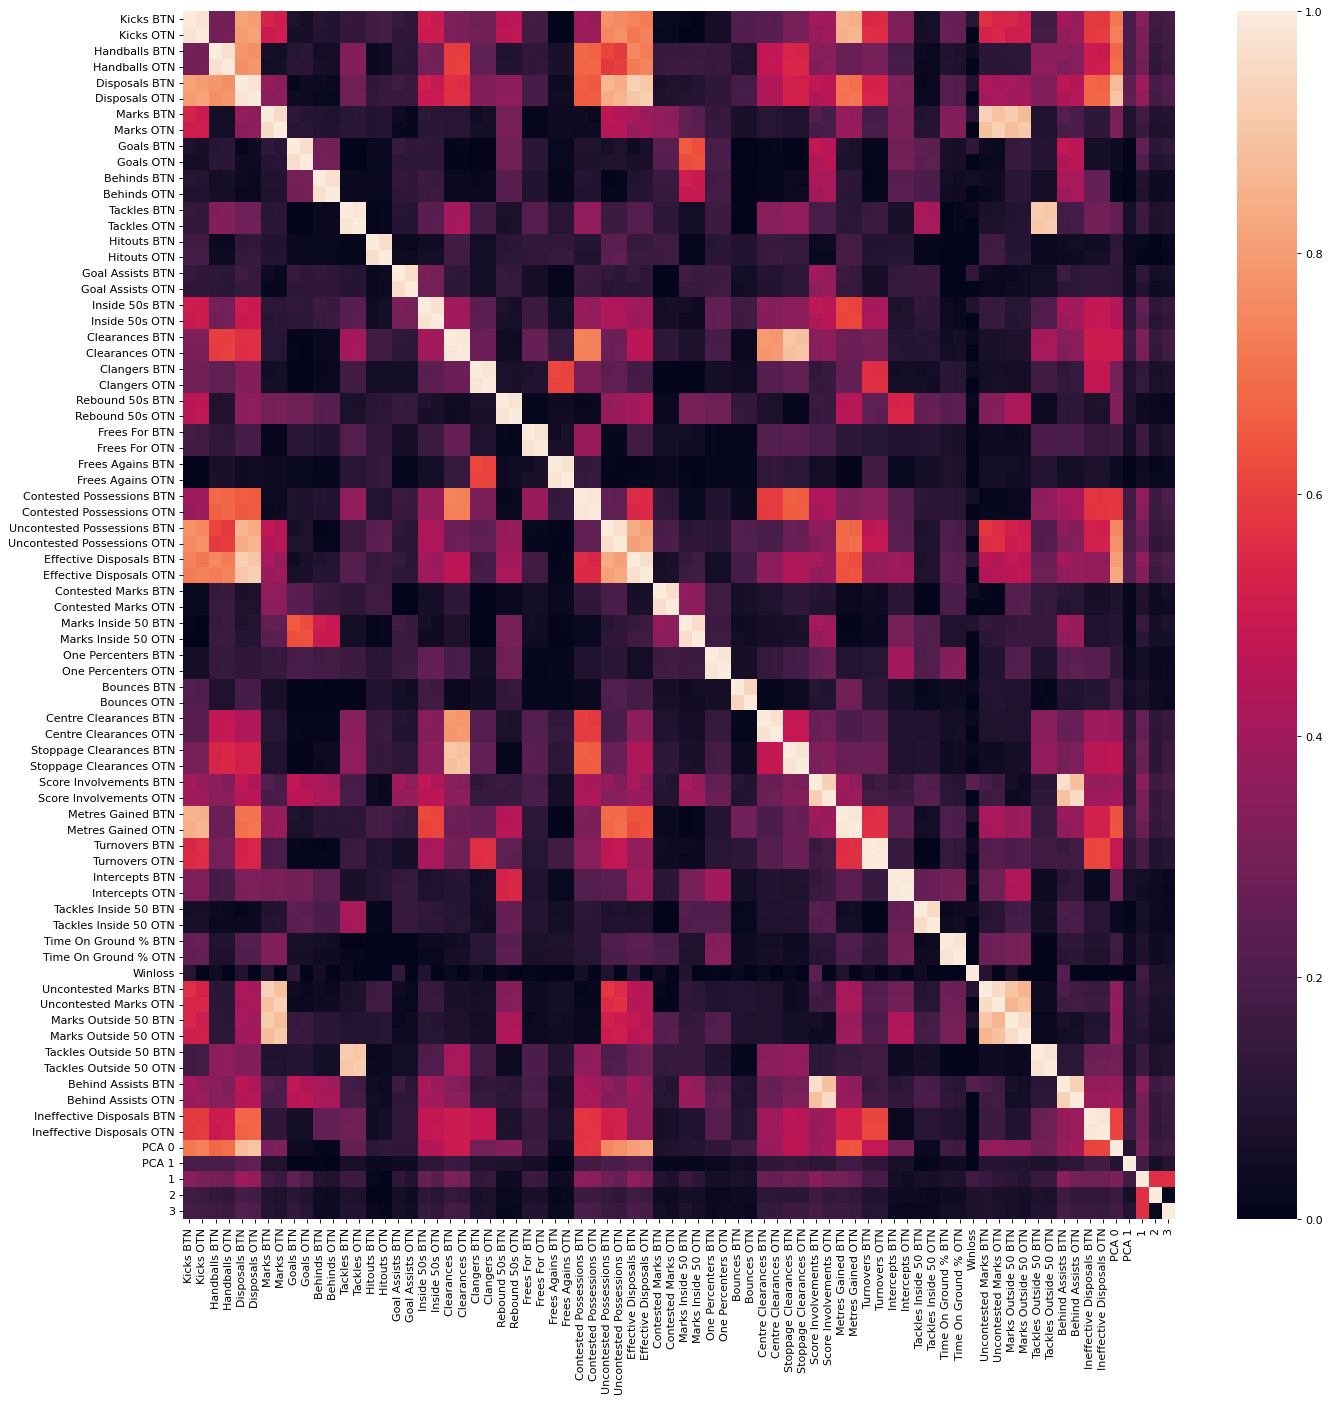

In [77]:
zhongshan.get_corr_heatmap()

In [78]:
zhongshan.view_top_corr()

Correlation between features and 1


,index,1
0,1,1.000000
1,2,0.563813
2,3,0.563813
3,Disposals BTN,0.396278
4,Disposals OTN,0.371130
5,Contested Possessions BTN,0.362935
6,Effective Disposals BTN,0.360013
7,Score Involvements BTN,0.353299
8,Behind Assists BTN,0.347265
9,Contested Possessions OTN,0.341696


Correlation between features and 2


,index,2
0,2,1.000000
1,1,0.563813
2,Disposals BTN,0.185983
3,Disposals OTN,0.174287
4,Effective Disposals BTN,0.169276
5,Kicks BTN,0.164212
6,Contested Possessions BTN,0.160699
7,Score Involvements BTN,0.158034
8,Behind Assists BTN,0.156812
9,Effective Disposals OTN,0.154960


Correlation between features and 3


,index,3
0,3,1.000000
1,1,0.563813
2,Disposals BTN,0.218210
3,Disposals OTN,0.204496
4,Effective Disposals BTN,0.199533
5,Contested Possessions BTN,0.199359
6,Score Involvements BTN,0.189634
7,Contested Possessions OTN,0.187358
8,Behind Assists BTN,0.186402
9,Effective Disposals OTN,0.184529


In [79]:
zhongshan.get_nmi()

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for t

In [80]:
zhongshan.view_nmi_matrix()

,Kicks BTN,Kicks OTN,Handballs BTN,Handballs OTN,Disposals BTN,Disposals OTN,Marks BTN,Marks OTN,Goals BTN,Goals OTN,...,Tackles Outside 50 OTN,Behind Assists BTN,Behind Assists OTN,Ineffective Disposals BTN,Ineffective Disposals OTN,PCA 0,PCA 1,1,2,3
Kicks BTN,1.000000,0.969259,0.882787,0.897951,0.907180,0.918665,0.867653,0.870775,0.800412,0.711491,...,0.846578,0.862875,0.861735,0.872139,0.879485,0.393594,0.393594,0.033749,0.015599,0.016069
Kicks OTN,0.969259,1.000000,0.897089,0.918925,0.920718,0.938863,0.877106,0.892895,0.792999,0.740827,...,0.869677,0.873419,0.884224,0.882415,0.901268,0.438932,0.438932,0.037616,0.016947,0.017363
Handballs BTN,0.882787,0.897089,1.000000,0.968345,0.901679,0.913316,0.859612,0.863900,0.803549,0.711550,...,0.844668,0.860627,0.858227,0.868574,0.875014,0.381757,0.381757,0.033276,0.015741,0.015989
Handballs OTN,0.897951,0.918925,0.968345,1.000000,0.916213,0.934539,0.871210,0.887181,0.794637,0.742350,...,0.868858,0.870912,0.881830,0.878879,0.897857,0.429723,0.429723,0.037349,0.017097,0.017323
Disposals BTN,0.907180,0.920718,0.901679,0.916213,1.000000,0.979181,0.876052,0.884013,0.800900,0.722387,...,0.861507,0.874208,0.876745,0.884355,0.894506,0.431236,0.431236,0.039247,0.017162,0.017986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCA 0,0.393594,0.438932,0.381757,0.429723,0.431236,0.470547,0.325500,0.364596,0.125744,0.116522,...,0.317160,0.318952,0.349094,0.339917,0.385121,1.000000,1.000000,0.032092,0.007481,0.009943
PCA 1,0.393594,0.438932,0.381757,0.429723,0.431236,0.470547,0.325500,0.364596,0.125744,0.116522,...,0.317160,0.318952,0.349094,0.339917,0.385121,1.000000,1.000000,0.032092,0.007481,0.009943
1,0.033749,0.037616,0.033276,0.037349,0.039247,0.041658,0.022699,0.026570,0.015510,0.015673,...,0.023590,0.029548,0.030382,0.028296,0.032304,0.032092,0.032092,1.000000,0.364280,0.364280
2,0.015599,0.016947,0.015741,0.017097,0.017162,0.018322,0.012247,0.013511,0.008033,0.007572,...,0.012260,0.013525,0.013994,0.013748,0.015066,0.007481,0.007481,0.364280,1.000000,0.004852


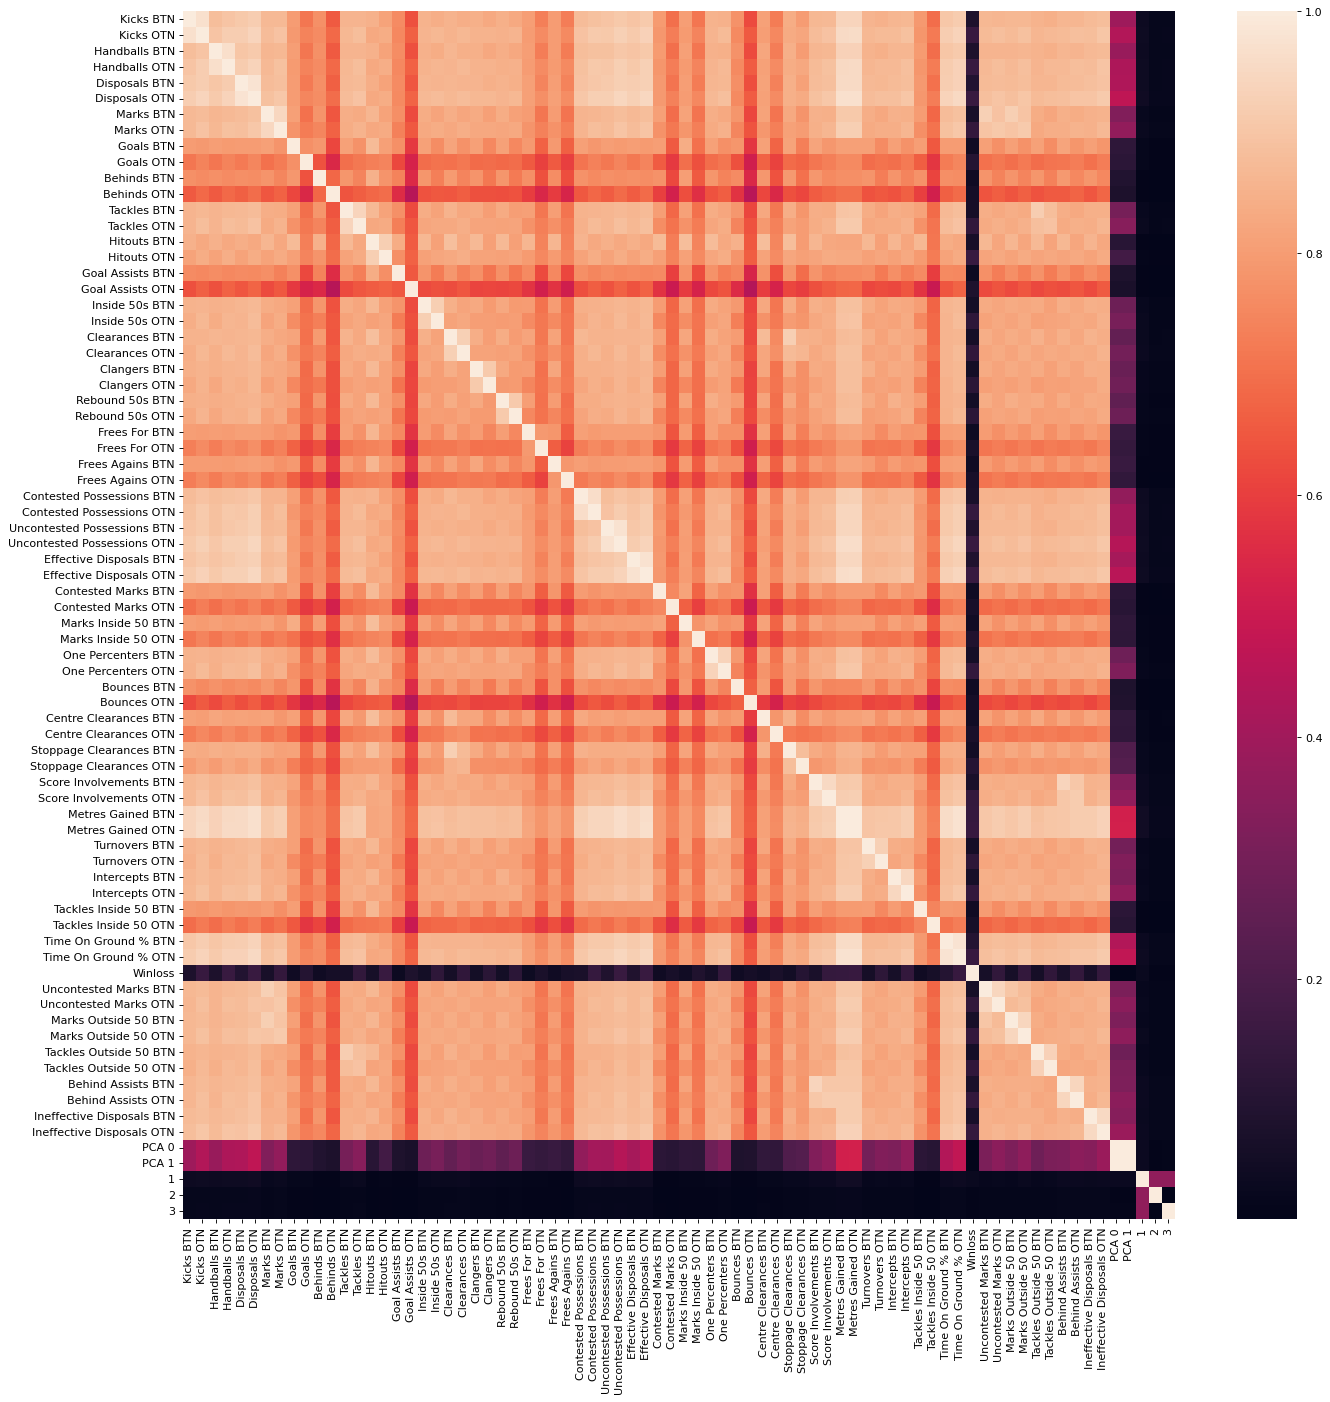

In [81]:
zhongshan.get_nmi_heatmap()

In [82]:
zhongshan.view_top_nmi()

NMI between features and 1


,index,1
0,1,1.000000
1,3,0.364280
2,2,0.364280
3,Metres Gained OTN,0.045289
4,Metres Gained BTN,0.044894
5,Disposals OTN,0.041658
6,Effective Disposals OTN,0.039382
7,Disposals BTN,0.039247
8,Uncontested Possessions OTN,0.037664
9,Kicks OTN,0.037616


NMI between features and 2


,index,2
0,2,1.000000
1,1,0.364280
2,Metres Gained OTN,0.019955
3,Metres Gained BTN,0.019854
4,Disposals OTN,0.018322
5,Effective Disposals OTN,0.017680
6,Uncontested Possessions OTN,0.017183
7,Disposals BTN,0.017162
8,Handballs OTN,0.017097
9,Kicks OTN,0.016947


NMI between features and 3


,index,3
0,3,1.000000
1,1,0.364280
2,Metres Gained OTN,0.020027
3,Metres Gained BTN,0.019917
4,Disposals OTN,0.018743
5,Effective Disposals OTN,0.017990
6,Disposals BTN,0.017986
7,Uncontested Possessions OTN,0.017439
8,Kicks OTN,0.017363
9,Handballs OTN,0.017323


Feature-Label Data IDE on column 'Frees For OTN'


1    0.151322
2    0.065820
3    0.088026
Name: Frees For OTN, dtype: float64

1    0.011397
2    0.006285
3    0.006703
Name: Frees For OTN, dtype: float64

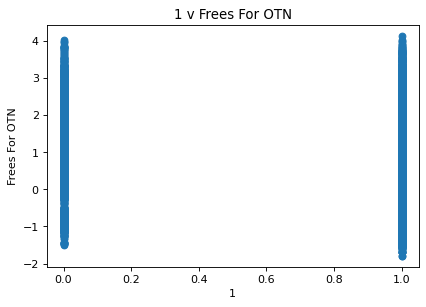

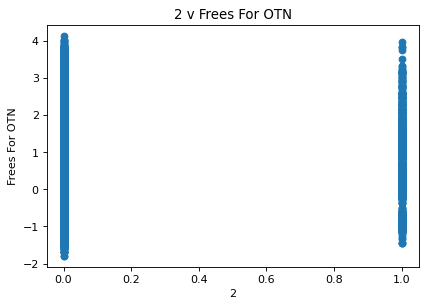

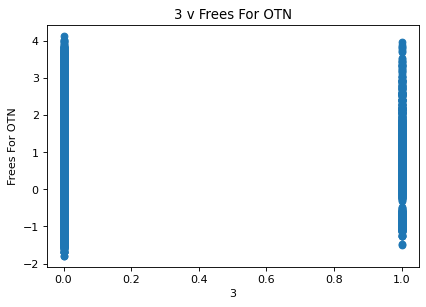

In [83]:
zhongshan.view_feature_label_analysis('Frees For OTN', 'categorical')

In [36]:
zhongshan.feature_selection(0.1)

Read in feature selection cutoff value at 0.1


In [37]:
zhongshan.get_selected_features()

Successfully got selected features


In [38]:
zhongshan.final_features

{'1': ['Kicks BTN',
  'Kicks OTN',
  'Handballs BTN',
  'Handballs OTN',
  'Disposals BTN',
  'Disposals OTN',
  'Marks BTN',
  'Marks OTN',
  'Goals BTN',
  'Goals OTN',
  'Tackles BTN',
  'Tackles OTN',
  'Goal Assists BTN',
  'Inside 50s BTN',
  'Inside 50s OTN',
  'Clearances BTN',
  'Clearances OTN',
  'Clangers BTN',
  'Clangers OTN',
  'Frees For BTN',
  'Frees For OTN',
  'Contested Possessions BTN',
  'Contested Possessions OTN',
  'Uncontested Possessions BTN',
  'Uncontested Possessions OTN',
  'Effective Disposals BTN',
  'Effective Disposals OTN',
  'Marks Inside 50 BTN',
  'Marks Inside 50 OTN',
  'Centre Clearances BTN',
  'Centre Clearances OTN',
  'Stoppage Clearances BTN',
  'Stoppage Clearances OTN',
  'Score Involvements BTN',
  'Score Involvements OTN',
  'Metres Gained BTN',
  'Metres Gained OTN',
  'Turnovers BTN',
  'Turnovers OTN',
  'Winloss',
  'Uncontested Marks BTN',
  'Uncontested Marks OTN',
  'Marks Outside 50 BTN',
  'Tackles Outside 50 BTN',
  'Tackles

In [39]:
sanmin = SanMin(zhongshan)

In [41]:
sanmin.retained_columns

['Kicks BTN',
 'Kicks OTN',
 'Handballs BTN',
 'Handballs OTN',
 'Disposals BTN',
 'Disposals OTN',
 'Marks BTN',
 'Marks OTN',
 'Goals BTN',
 'Goals OTN',
 'Behinds BTN',
 'Behinds OTN',
 'Tackles BTN',
 'Tackles OTN',
 'Hitouts BTN',
 'Hitouts OTN',
 'Goal Assists BTN',
 'Goal Assists OTN',
 'Inside 50s BTN',
 'Inside 50s OTN',
 'Clearances BTN',
 'Clearances OTN',
 'Clangers BTN',
 'Clangers OTN',
 'Rebound 50s BTN',
 'Rebound 50s OTN',
 'Frees For BTN',
 'Frees For OTN',
 'Frees Agains BTN',
 'Frees Agains OTN',
 'Contested Possessions BTN',
 'Contested Possessions OTN',
 'Uncontested Possessions BTN',
 'Uncontested Possessions OTN',
 'Effective Disposals BTN',
 'Effective Disposals OTN',
 'Contested Marks BTN',
 'Contested Marks OTN',
 'Marks Inside 50 BTN',
 'Marks Inside 50 OTN',
 'One Percenters BTN',
 'One Percenters OTN',
 'Bounces BTN',
 'Bounces OTN',
 'Centre Clearances BTN',
 'Centre Clearances OTN',
 'Stoppage Clearances BTN',
 'Stoppage Clearances OTN',
 'Score Involvem